## NVDIA STOCK

image: 
- title gramma
- aesthetics
- x,Y

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

[*********************100%***********************]  1 of 1 completed


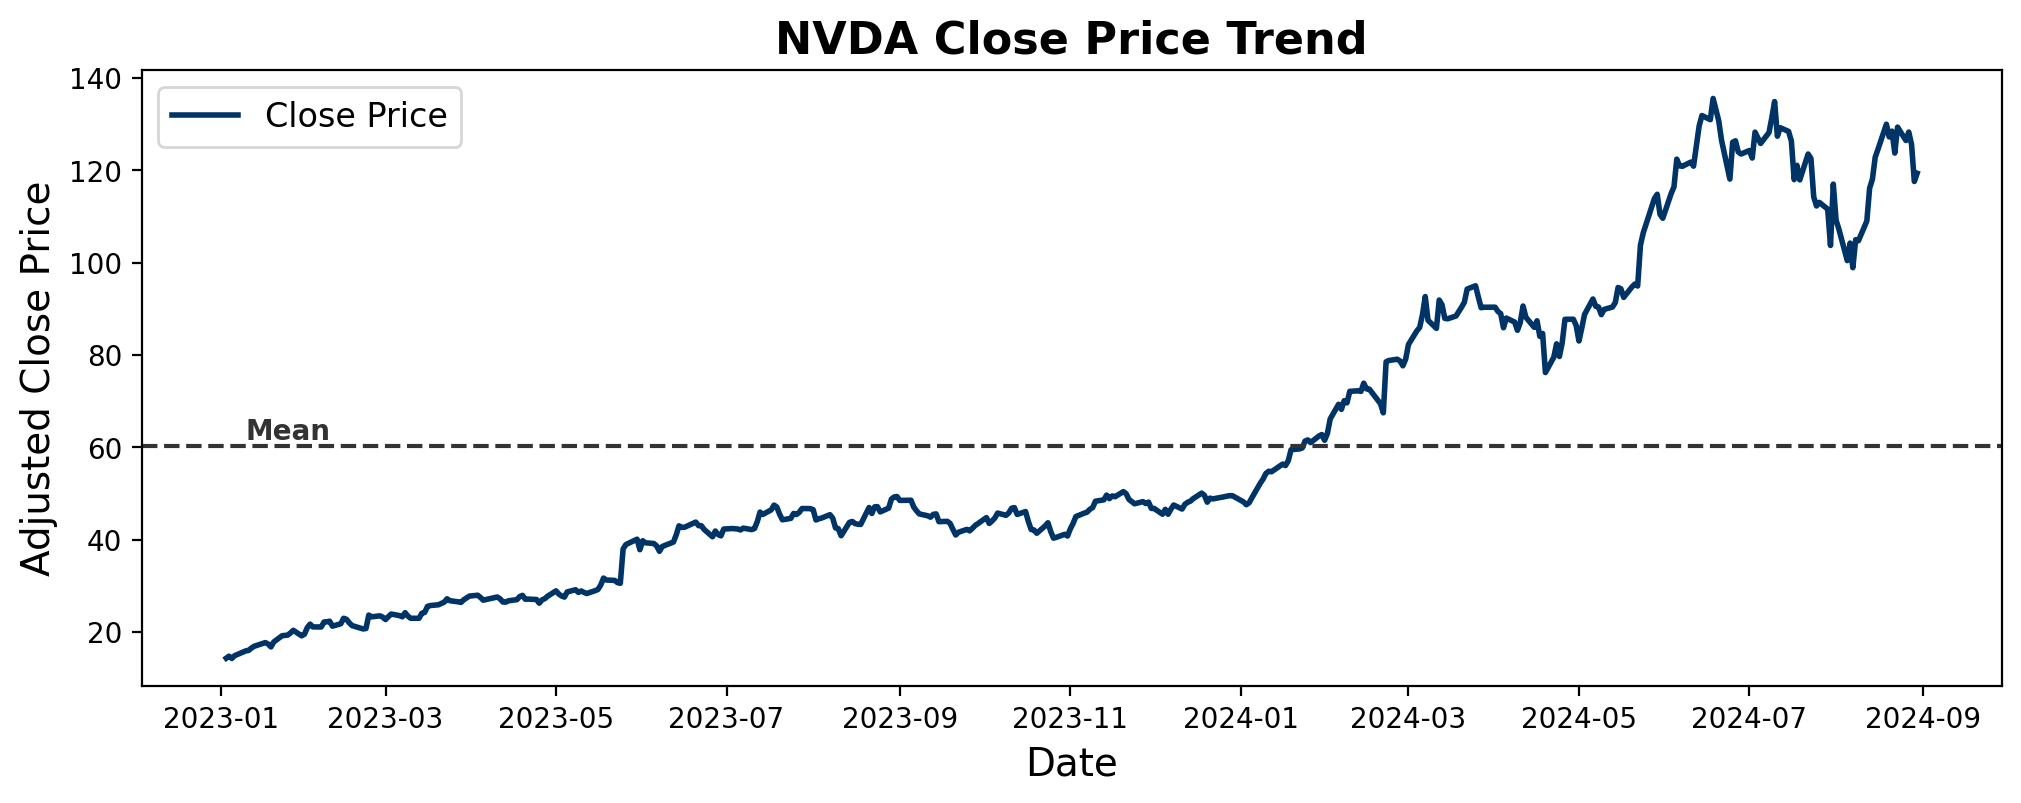

In [242]:
# Download stock data

stock_symbol = 'NVDA'
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 8, 31)
raw_data = yf.download(stock_symbol, start_date, end_date)

## data processing
data = raw_data.copy().stack().reset_index()
data['Close'] = data['Adj Close']  # Use 'Adj Close' for adjusted prices

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(data.set_index('Date')['Close'], label='Close Price', color='#003366', linewidth=2)
# 
# percentiles = [15, 50, 85]
# for perc in percentiles:
#     line_value = np.percentile(data['Close'], perc)
#     plt.axhline(line_value, color='#333333', linestyle='--', linewidth=1.5)
#     plt.text(data['Date'].iloc[5], line_value, f'{perc} Percentile', color='#333333', 
#              fontsize=10, ha='left', va='bottom', fontweight='bold')

line_value = data['Close'].mean()
plt.axhline(line_value, color='#333333', linestyle='--', linewidth=1.5)
plt.text(data['Date'].iloc[5], line_value, 'Mean', color='#333333', 
         fontsize=10, ha='left', va='bottom', fontweight='bold')

plt.title(f"{stock_symbol} Close Price Trend", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Adjusted Close Price", fontsize=14)

plt.legend(fontsize=12,loc='upper left')
plt.show()

## Technical Analysis:
To enhance your understanding of the stock data, apply the following technical analysis indicators:  
### Trend Identification:  
- Use Simple Moving Averages (SMA) and Exponential Moving Averages (EMA) to identify price trends.
### Overbought/Oversold Detection:
- Use the Relative Strength Index (RSI) to identify overbought or oversold conditions.
### Buying/Selling Pressure:
- Analyze On-Balance Volume (OBV) to assess the pressure of buying or selling activity.

### Trend Identification:
- #### Definition:
    - 𝑅𝑎𝑛𝑔𝑒 = 𝑀𝑖𝑑𝑝𝑟𝑖𝑐𝑒 ± 𝑆𝑝𝑟𝑒𝑎𝑑
    - Midprice:
    - Spread:
- #### Restriction:
    - **Stable Market Conditions:**
    The strategy performs best in range-bound or sideways markets where prices oscillate around a relatively stable mean. It's less effective in strongly trending markets.
    - **Consistent Volatility:**
    The strategy relies on measuring deviations from the mean. It works well when volatility is consistent enough to create reliable upper and lower bands.
    - **Mean Stability:**
    As you noted, the mean should be relatively steady. Rapid shifts in the average price can lead to false signals.
    - **Absence of Major Trends:**
    The strategy assumes prices will revert to the mean. In strongly trending markets, this assumption may not hold, reducing accuracy.
- #### Improvement:
    - auto calculate window based on vlotility

In [146]:
df = data.copy()

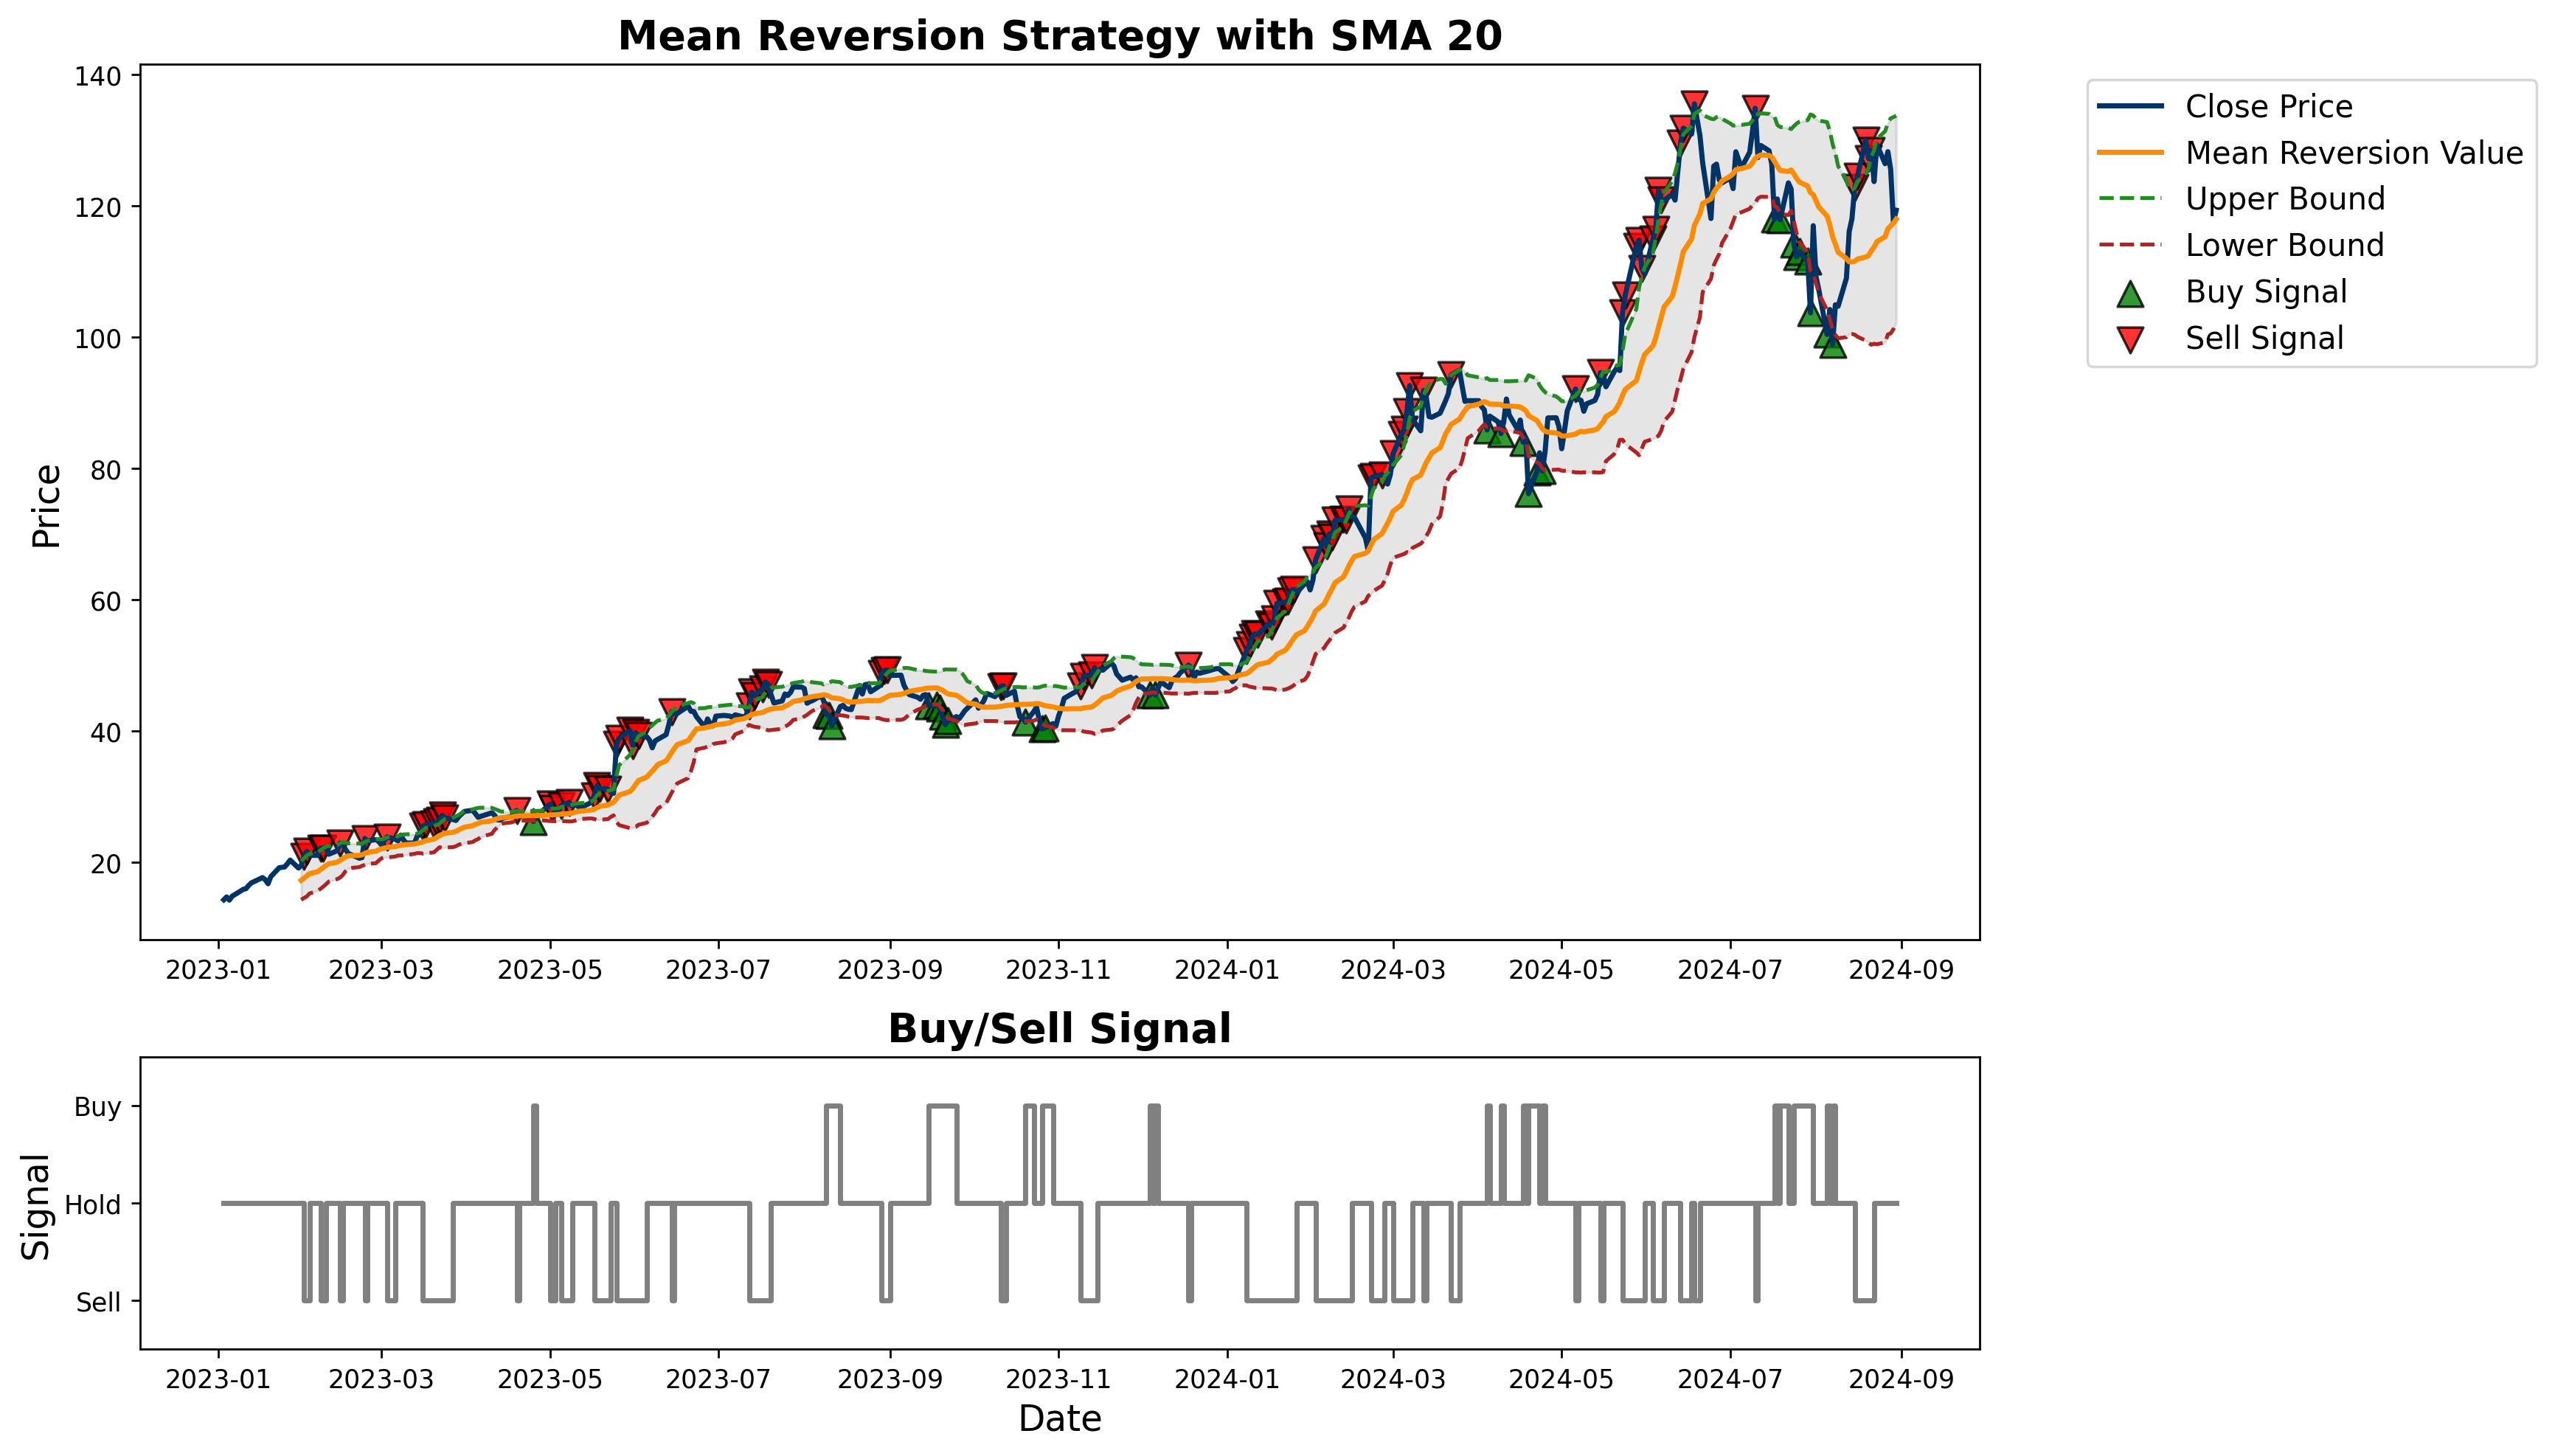

In [261]:
def mean_reversion_strategy(data, midprice_type, window, volatility_ratio):
    data = data.copy()
    
    # Calculate midprice (SMA or EMA)
    if midprice_type == "SMA":
        data['mr'] = data['Close'].rolling(window=window).mean()
    elif midprice_type == "EMA":
        data['mr'] = data['Close'].ewm(span=window, adjust=False).mean()
    
    # Calculate standard deviation (volatility)
    volatility = data['Close'].rolling(window=window).std()
    
    
    # Add calculated columns for visualization
    data['Upper Bound'] = data['mr'] + volatility_ratio * volatility
    data['Lower Bound'] = data['mr'] - volatility_ratio * volatility

    # Define buy/sell signals based on Z-score thresholds
    data['Signal'] = np.where(data['Close'] < data['Lower Bound'], 'Buy', 
                              np.where(data['Close'] > data['Upper Bound'], 'Sell', 'Hold'))

    return data

# Visualize and analyze results
def Original_visualize_signal(data_sma_zscore, midprice_col):
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), dpi=250, gridspec_kw={'height_ratios': [3, 1]})


    ax1 = axs[0]
    ax1.plot(data_sma_zscore.set_index('Date')['Close'], label='Close Price', color='#003366', linewidth=2)
    ax1.plot(data_sma_zscore.set_index('Date')[midprice_col], label='Mean Reversion Value', color='#FF8C00', linewidth=2)
    ax1.plot(data_sma_zscore.set_index('Date')['Upper Bound'], label='Upper Bound', color='#228B22', linestyle='--', linewidth=1.5)
    ax1.plot(data_sma_zscore.set_index('Date')['Lower Bound'], label='Lower Bound', color='#B22222', linestyle='--', linewidth=1.5)

    ax1.fill_between(data_sma_zscore.set_index('Date').index, 
                     data_sma_zscore['Lower Bound'], 
                     data_sma_zscore['Upper Bound'], 
                     color='gray', alpha=0.2)

    buy_signals = data_sma_zscore[data_sma_zscore['Signal'] == 'Buy']
    sell_signals = data_sma_zscore[data_sma_zscore['Signal'] == 'Sell']
    ax1.scatter(buy_signals.set_index('Date').index, 
                buy_signals['Close'], 
                marker='^', 
                color='green', 
                label='Buy Signal', 
                s=100, 
                alpha=0.8, 
                edgecolor='black')
    ax1.scatter(sell_signals.set_index('Date').index, 
                sell_signals['Close'], 
                marker='v', 
                color='red', 
                label='Sell Signal', 
                s=100, 
                alpha=0.8, 
                edgecolor='black')

    ax1.set_title("Mean Reversion Strategy with SMA 20", fontsize=16, fontweight='bold')
    ax1.set_ylabel("Price", fontsize=14)
    ax1.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1.05, 1))


    ax2 = axs[1]
    ax2.step(data_sma_zscore.set_index('Date').index, 
             data_sma_zscore['Signal'].replace({'Buy': 1, 'Sell': -1, 'Hold': 0}),
             where='post', 
             color='gray', linewidth=2)
    ax2.set_ylim(-1.5, 1.5)  # 设置y轴范围
    ax2.set_yticks([-1, 0, 1])
    ax2.set_yticklabels(['Sell', 'Hold', 'Buy'])
    ax2.set_title("Buy/Sell Signal", fontsize=16, fontweight='bold')
    ax2.set_xlabel("Date", fontsize=14)
    ax2.set_ylabel("Signal", fontsize=14)

    plt.tight_layout()
    plt.show()


  
# Mean reversion strategy
data_sma_zscore = mean_reversion_strategy(data, "SMA", 20, 1.5)


# Visualize long / short results
Original_visualize_signal(data_sma_zscore, 'mr')

### Optimized algorithm

In [255]:
# 
def ma_crossover_strategy(data, z_threshold=1.5):
    data = data.copy()

    # SMA20 & SMA50
    data['SMA20'] = data['Close'].rolling(window=20).mean()
    data['SMA50'] = data['Close'].rolling(window=50).mean()

    # Calculate Z-score
    volatility = data['Close'].rolling(window=20).std()
    data['Z-score'] = (data['Close'] - data['SMA20']) / volatility
    
    # MA crossover 
    data['Signal'] = np.where(
        (data['SMA20'] > data['SMA50']) & (data['Z-score'] < -z_threshold), 'Buy',  # up + Z-score
        np.where((data['SMA20'] < data['SMA50']) & (data['Z-score'] > z_threshold), 'Sell',  # down - Z-score
                            'Hold'))

    # Upper & Lowerbound
    data['Upper Bound'] = data['SMA20'] + z_threshold * volatility
    data['Lower Bound'] = data['SMA20'] - z_threshold * volatility

    return data

data_strategy = ma_crossover_strategy(data, z_threshold=1.5)

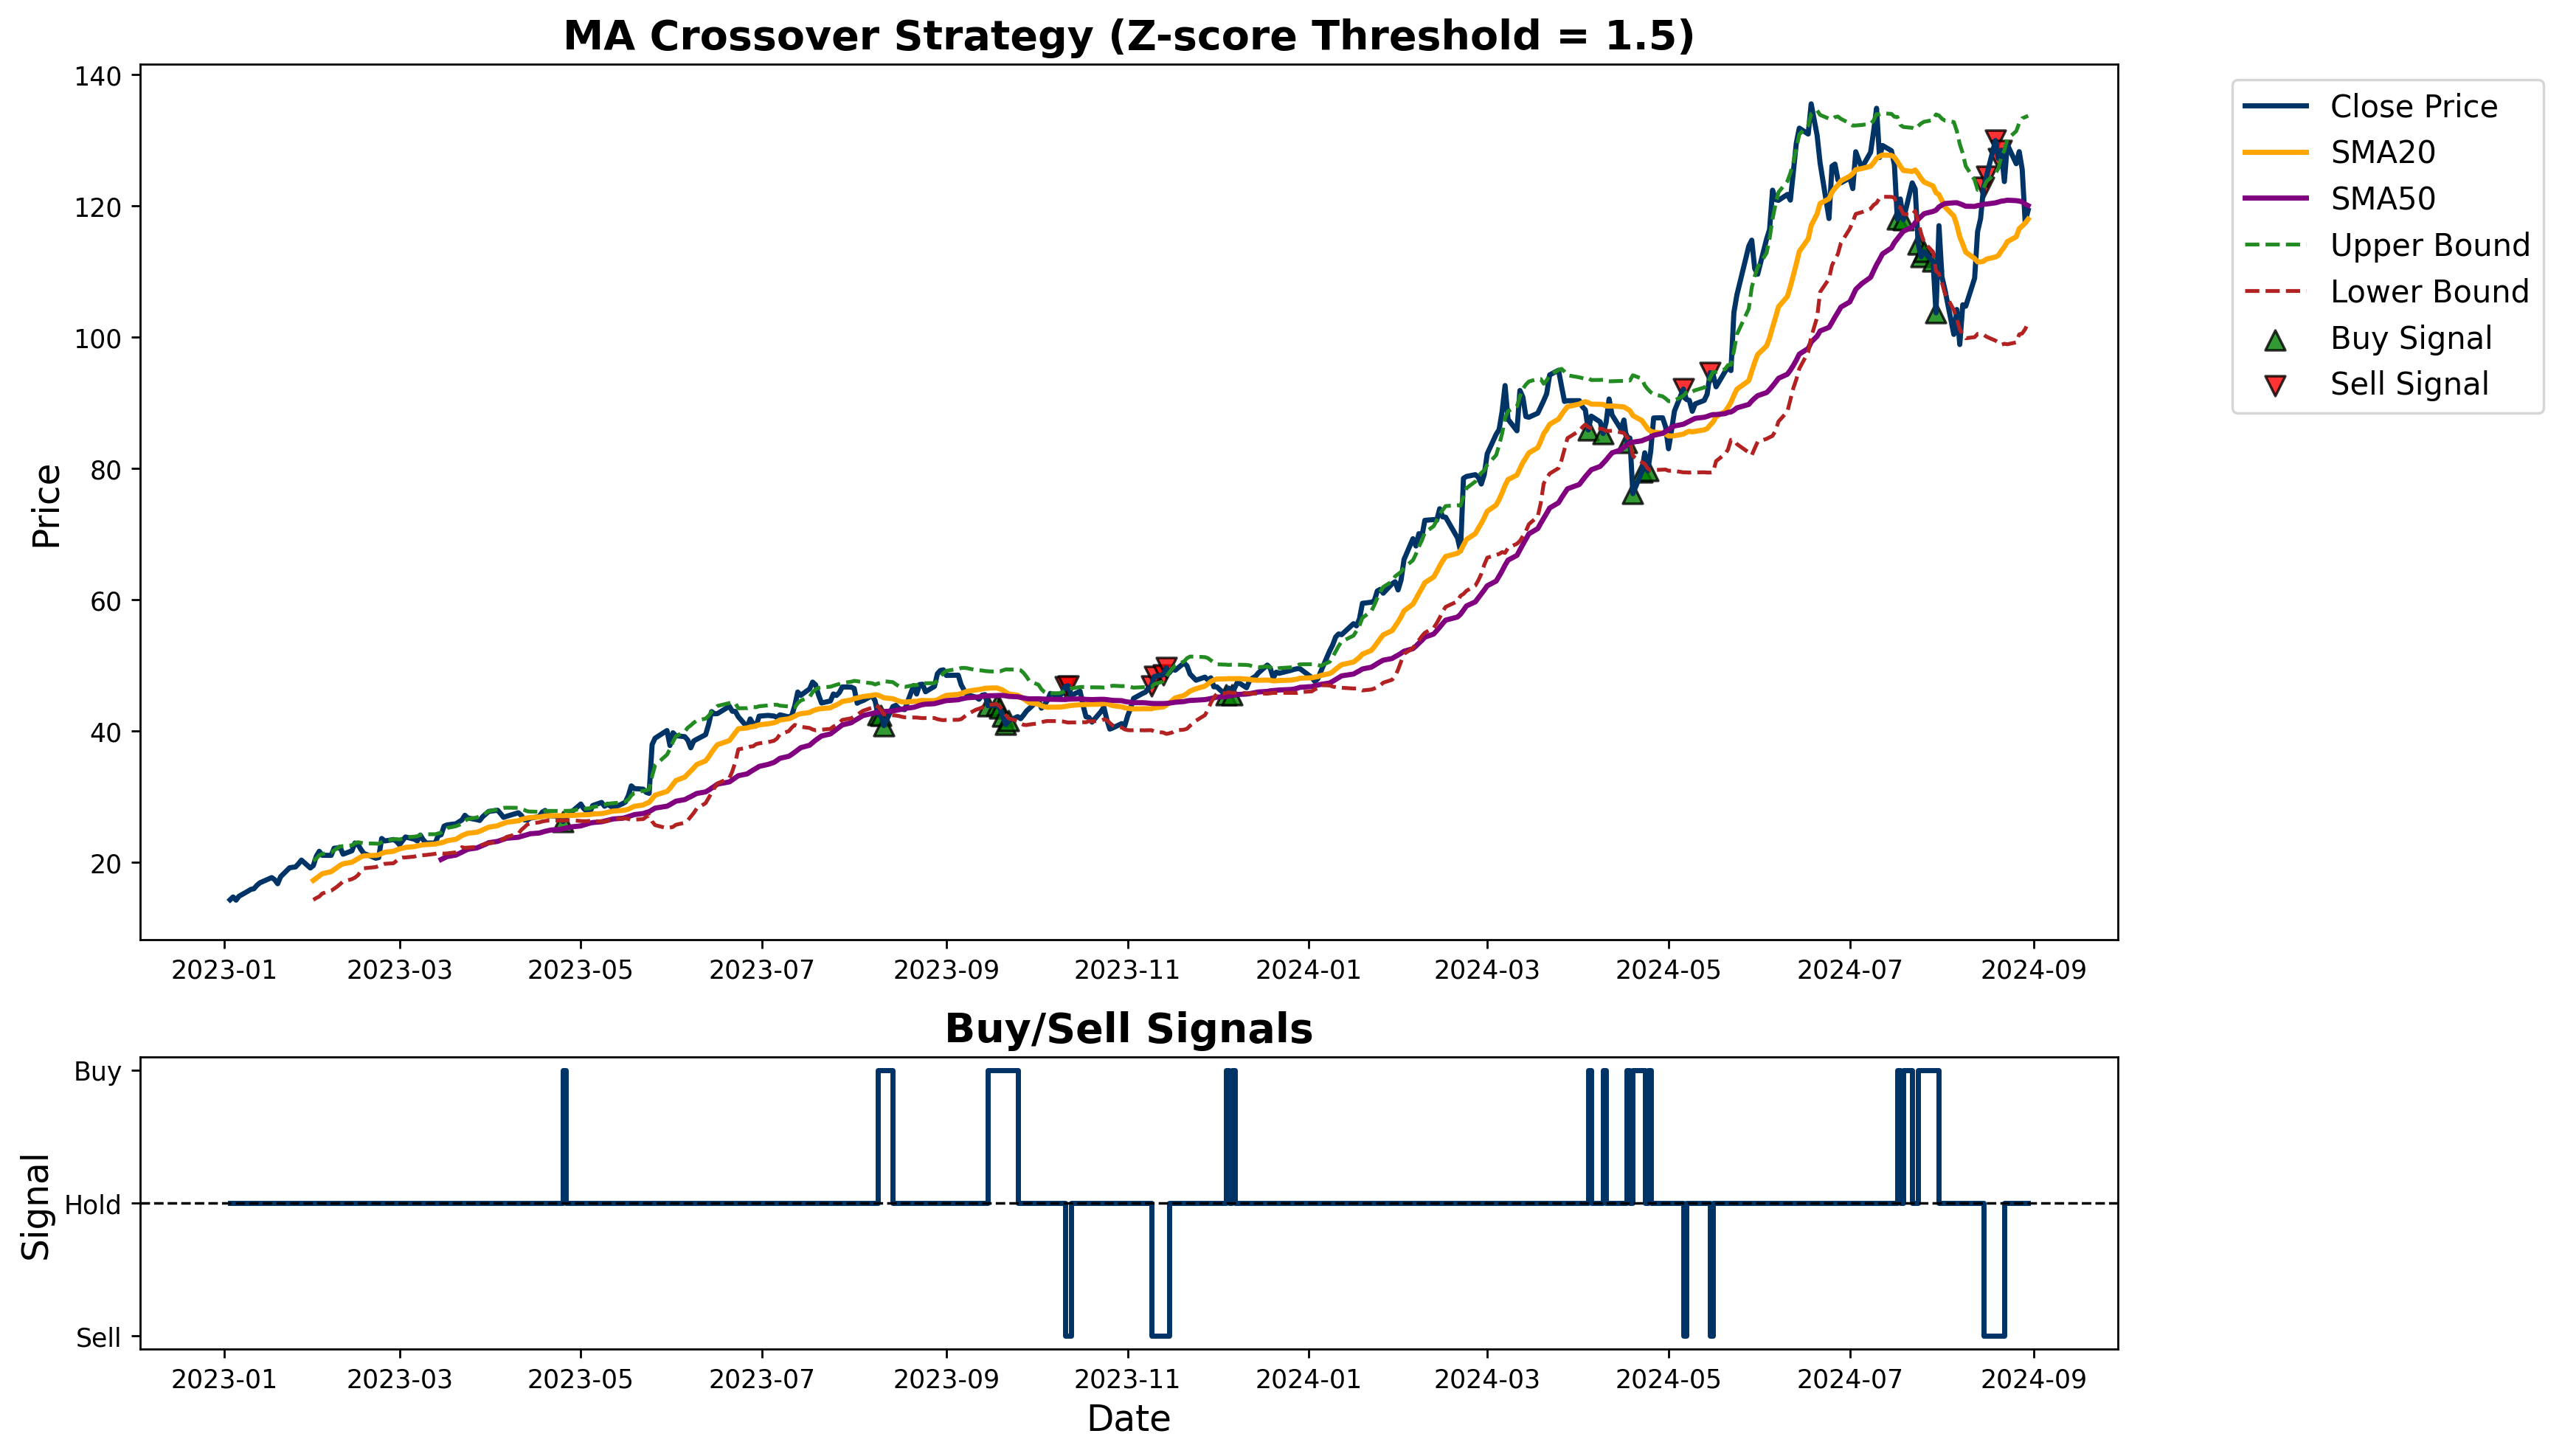

In [254]:

# 可视化优化后的多头/空头结果
def Optimized_visualize_with_subplot(data_strategy):
    # 设置子图的高度比例
    fig, ax = plt.subplots(2, 1, figsize=(14, 8), dpi=250, gridspec_kw={'height_ratios': [3, 1]})

    # 上面子图：均值回归图表
    ax[0].plot(data_strategy.set_index('Date')['Close'], label='Close Price', color='#003366', linewidth=2)
    ax[0].plot(data_strategy.set_index('Date')['SMA20'], label='SMA20', color='#FFA500', linewidth=2)
    ax[0].plot(data_strategy.set_index('Date')['SMA50'], label='SMA50', color='#800080', linewidth=2)
    ax[0].plot(data_strategy.set_index('Date')['Upper Bound'], label='Upper Bound', color='#228B22', linestyle='--', linewidth=1.5)
    ax[0].plot(data_strategy.set_index('Date')['Lower Bound'], label='Lower Bound', color='#B22222', linestyle='--', linewidth=1.5)
    
    buy_signals = data_strategy[data_strategy['Signal'] == 'Buy']
    sell_signals = data_strategy[data_strategy['Signal'] == 'Sell']
    ax[0].scatter(buy_signals.set_index('Date').index, buy_signals['Close'], marker='^', color='green', label='Buy Signal', s=60, alpha=0.8, edgecolor='black')
    ax[0].scatter(sell_signals.set_index('Date').index, sell_signals['Close'], marker='v', color='red', label='Sell Signal', s=60, alpha=0.8, edgecolor='black')
    
    ax[0].set_title("MA Crossover Strategy (Z-score Threshold = 1.5)", fontsize=16, fontweight='bold')
    ax[0].set_ylabel("Price", fontsize=14)
    ax[0].legend(fontsize=12, loc='upper left', bbox_to_anchor=(1.05, 1))

    # 下面子图：买入卖出方形波图
    ax[1].step(data_strategy['Date'], data_strategy['Signal'].apply(lambda x: 1 if x == 'Buy' else (-1 if x == 'Sell' else 0)), where='post', color='#003366', linewidth=2)
    ax[1].set_title("Buy/Sell Signals", fontsize=16, fontweight='bold')
    ax[1].set_xlabel("Date", fontsize=14)
    ax[1].set_ylabel("Signal", fontsize=14)
    ax[1].axhline(0, color='black', linestyle='--', linewidth=1)
    ax[1].set_yticks([-1, 0, 1])
    ax[1].set_yticklabels(['Sell', 'Hold', 'Buy'])

    plt.tight_layout()
    plt.show()

# 使用优化后的可视化函数
Optimized_visualize_with_subplot(data_strategy)


### Overbought/Oversold Detection:
- Definition:
- Restriction:
- Improvement:
Overbought/Oversold Detection:
Use the Relative Strength Index (RSI) to identify overbought or oversold conditions.
The 80 level usually becomes the overbought level in bull markets and 20 level the oversold
level in bear markets.
• 14 days are usually used in the calculation.
• The 50 level is the RSI midpoint value, and will often act as support during pullbacks and
resistance during bounces. Some traders treat RSI crossings above and below the 50 level as
buying and selling signals respectively.

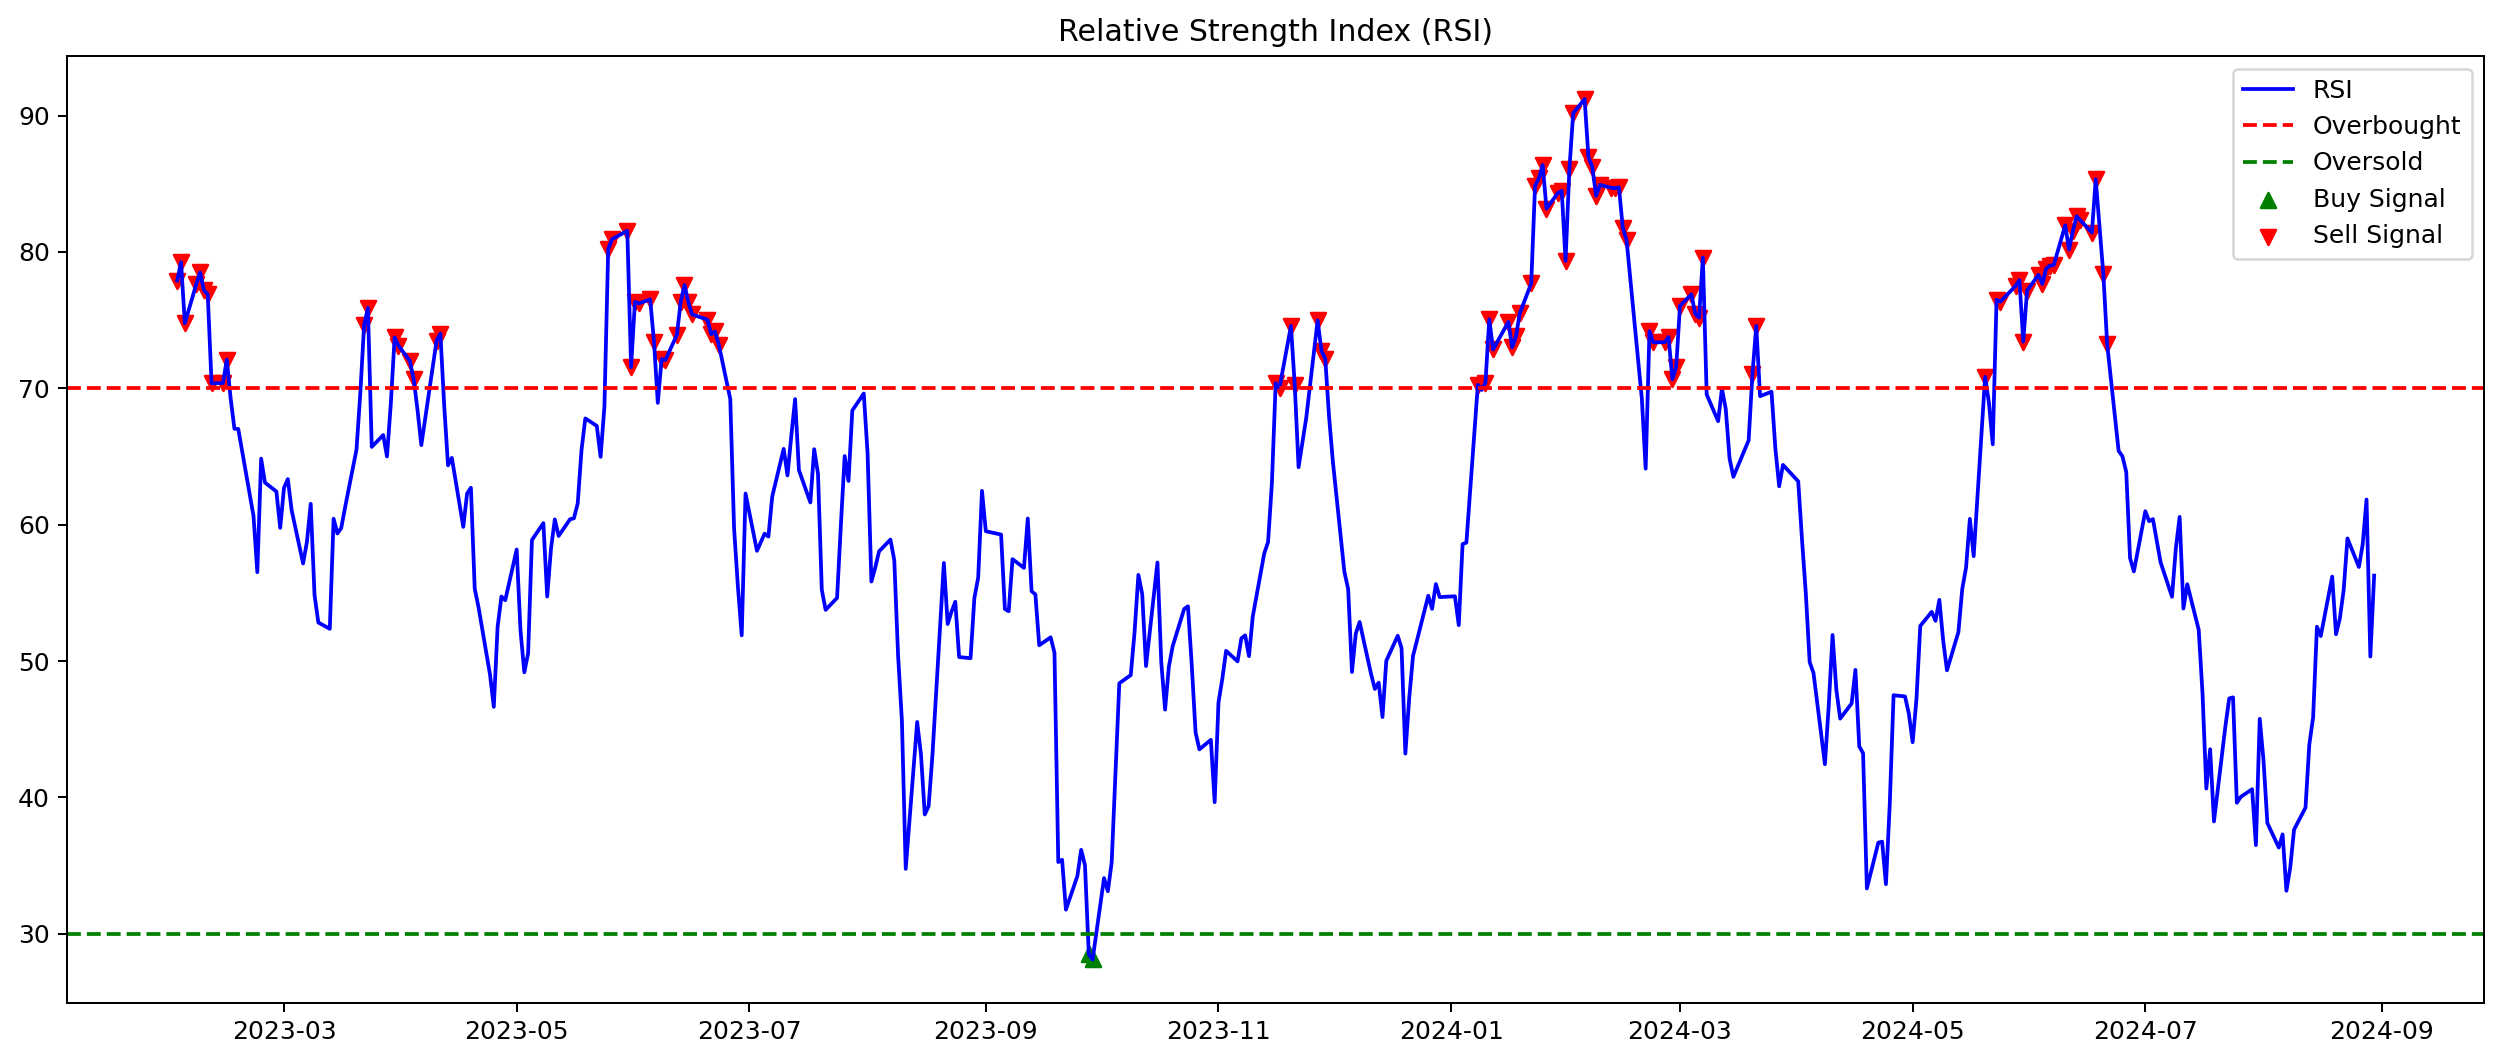

In [221]:
def calculate_rs(data, window):
    """  𝑅𝑆 = 𝐴𝑣𝑒𝑟𝑎𝑔𝑒 𝑜𝑓 𝑥 𝑑𝑎𝑦𝑠′𝑢𝑝 𝑐𝑙𝑜𝑠𝑒𝑠/𝐴𝑣𝑒𝑟𝑎𝑔𝑒 𝑜𝑓 𝑥 𝑑𝑎𝑦𝑠′ 𝑑𝑜𝑤𝑛 𝑐𝑙𝑜𝑠𝑒𝑠 """
    data = data.copy()
    
    # Calculate up closes & down closes
    up_closes = data['Close'].diff().apply(lambda x: x if x > 0 else 0)
    down_closes = data['Close'].diff().apply(lambda x: abs(x) if x < 0 else 0)
    
    # Calculate the moving average 
    avg_up_closes = up_closes.rolling(window=window).mean()
    avg_up_down = down_closes.rolling(window=window).mean()
    
    return avg_up_closes/avg_up_down


def calculate_rsi(data, window, oversold_level, overbought_level):
    """ 𝑅𝑆𝐼 = 100 − 100/(1 + 𝑅𝑆) """
    data = data.copy()
    
    rs = calculate_rs(data, window)

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))
    
    # Add RSI to the DataFrame
    data['RSI'] = rsi
    
    # Identify buy/sell signals
    data['RSI_Signal'] = np.where(data['RSI'] < oversold_level, 'Oversold Level',
                                  np.where(data['RSI'] > overbought_level, 'Overbought Level', 
                                  np.where(data['RSI'] < 50, 'Buying Signal','Selling Signal')))
    
    return data

data_rsi = calculate_rsi(data, window=21, oversold_level=30, overbought_level=70)

# Show buy and sell signals
buy_signals = data_rsi[data_rsi['RSI_Signal'] == 'Oversold Level']
sell_signals = data_rsi[data_rsi['RSI_Signal'] == 'Overbought Level']

# RSI Plot
plt.figure(figsize=(14, 6), dpi=180) 
plt.plot(data_rsi.set_index('Date')['RSI'], label='RSI', color='blue')
plt.axhline(70, color='red', linestyle='--', label='Overbought')
plt.axhline(30, color='green', linestyle='--', label='Oversold')
plt.scatter(buy_signals.set_index('Date').index, buy_signals['RSI'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.set_index('Date').index, sell_signals['RSI'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.title("Relative Strength Index (RSI)")
plt.legend()

plt.tight_layout()
plt.show()

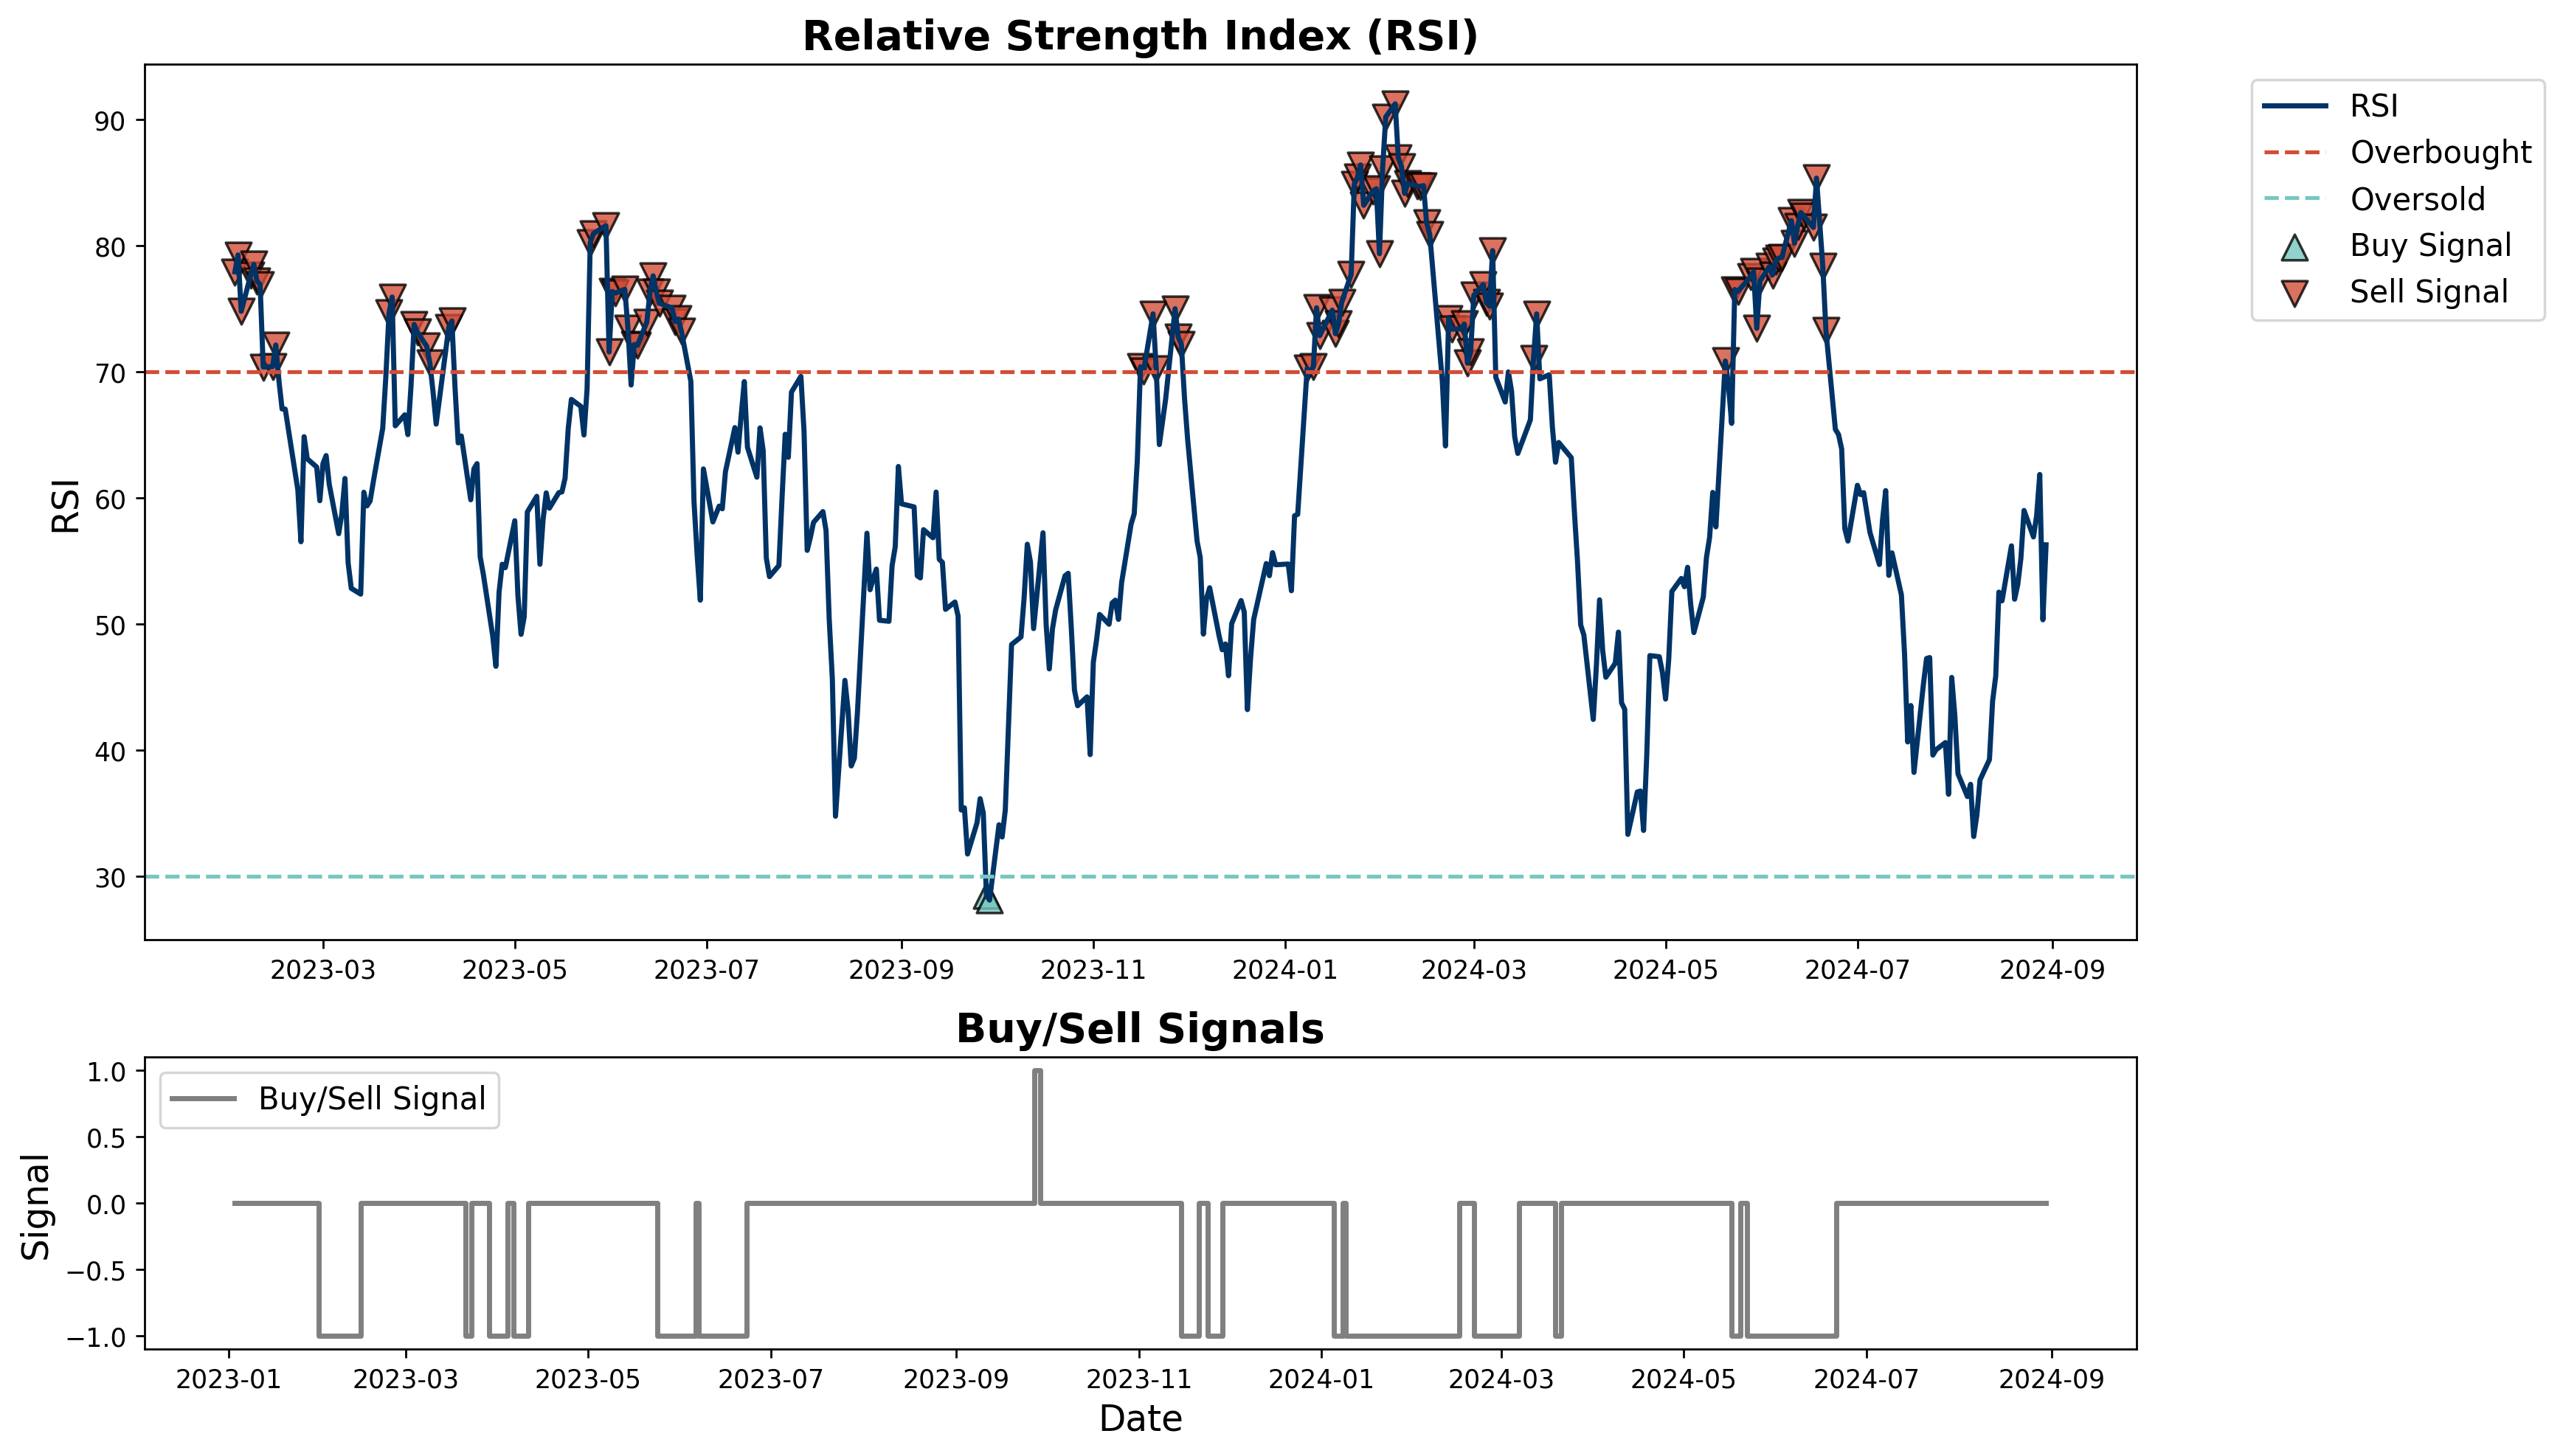

In [277]:
import matplotlib.pyplot as plt

def visualize_rsi_and_signals(data_rsi, buy_signals, sell_signals):
    fig, axs = plt.subplots(2, 1, figsize=(14, 8), dpi=250, gridspec_kw={'height_ratios': [3, 1]})
    

    # 上图：RSI图
    axs[0].plot(data_rsi.set_index('Date')['RSI'], label='RSI', color='#003366', linewidth=2)
    axs[0].axhline(70, color='#D24D37', linestyle='--', label='Overbought', linewidth=1.5)
    axs[0].axhline(30, color='#76C7C0', linestyle='--', label='Oversold', linewidth=1.5)

    axs[0].scatter(buy_signals.set_index('Date').index, buy_signals['RSI'], 
                   marker='^', color='#76C7C0', label='Buy Signal', s=100, alpha=0.8, edgecolor='black')
    axs[0].scatter(sell_signals.set_index('Date').index, sell_signals['RSI'], 
                   marker='v', color='#D24D37', label='Sell Signal', s=100, alpha=0.8, edgecolor='black')

    axs[0].set_title("Relative Strength Index (RSI)", fontsize=16, fontweight='bold')
    axs[0].set_ylabel("RSI", fontsize=14)
    axs[0].legend(fontsize=12, loc='upper left', bbox_to_anchor=(1.05, 1))

    # 下图：买入卖出信号的方形波图
    signals = pd.Series(0, index=data_rsi['Date'], dtype=int)
    signals[buy_signals.set_index('Date').index] = 1  # 买入信号
    signals[sell_signals.set_index('Date').index] = -1  # 卖出信号

    axs[1].step(data_rsi['Date'], signals, label='Buy/Sell Signal', color='gray', linewidth=2)
    
    axs[1].set_title("Buy/Sell Signals", fontsize=16, fontweight='bold')
    axs[1].set_xlabel("Date", fontsize=14)
    axs[1].set_ylabel("Signal", fontsize=14)

    axs[1].legend(fontsize=12, loc='upper left')

    plt.tight_layout()
    plt.show()

# 使用可视化函数
visualize_rsi_and_signals(data_rsi, buy_signals, sell_signals)

### Buying/Selling Pressure:
- Analyze On-Balance Volume (OBV) to assess the pressure of buying or selling activity.

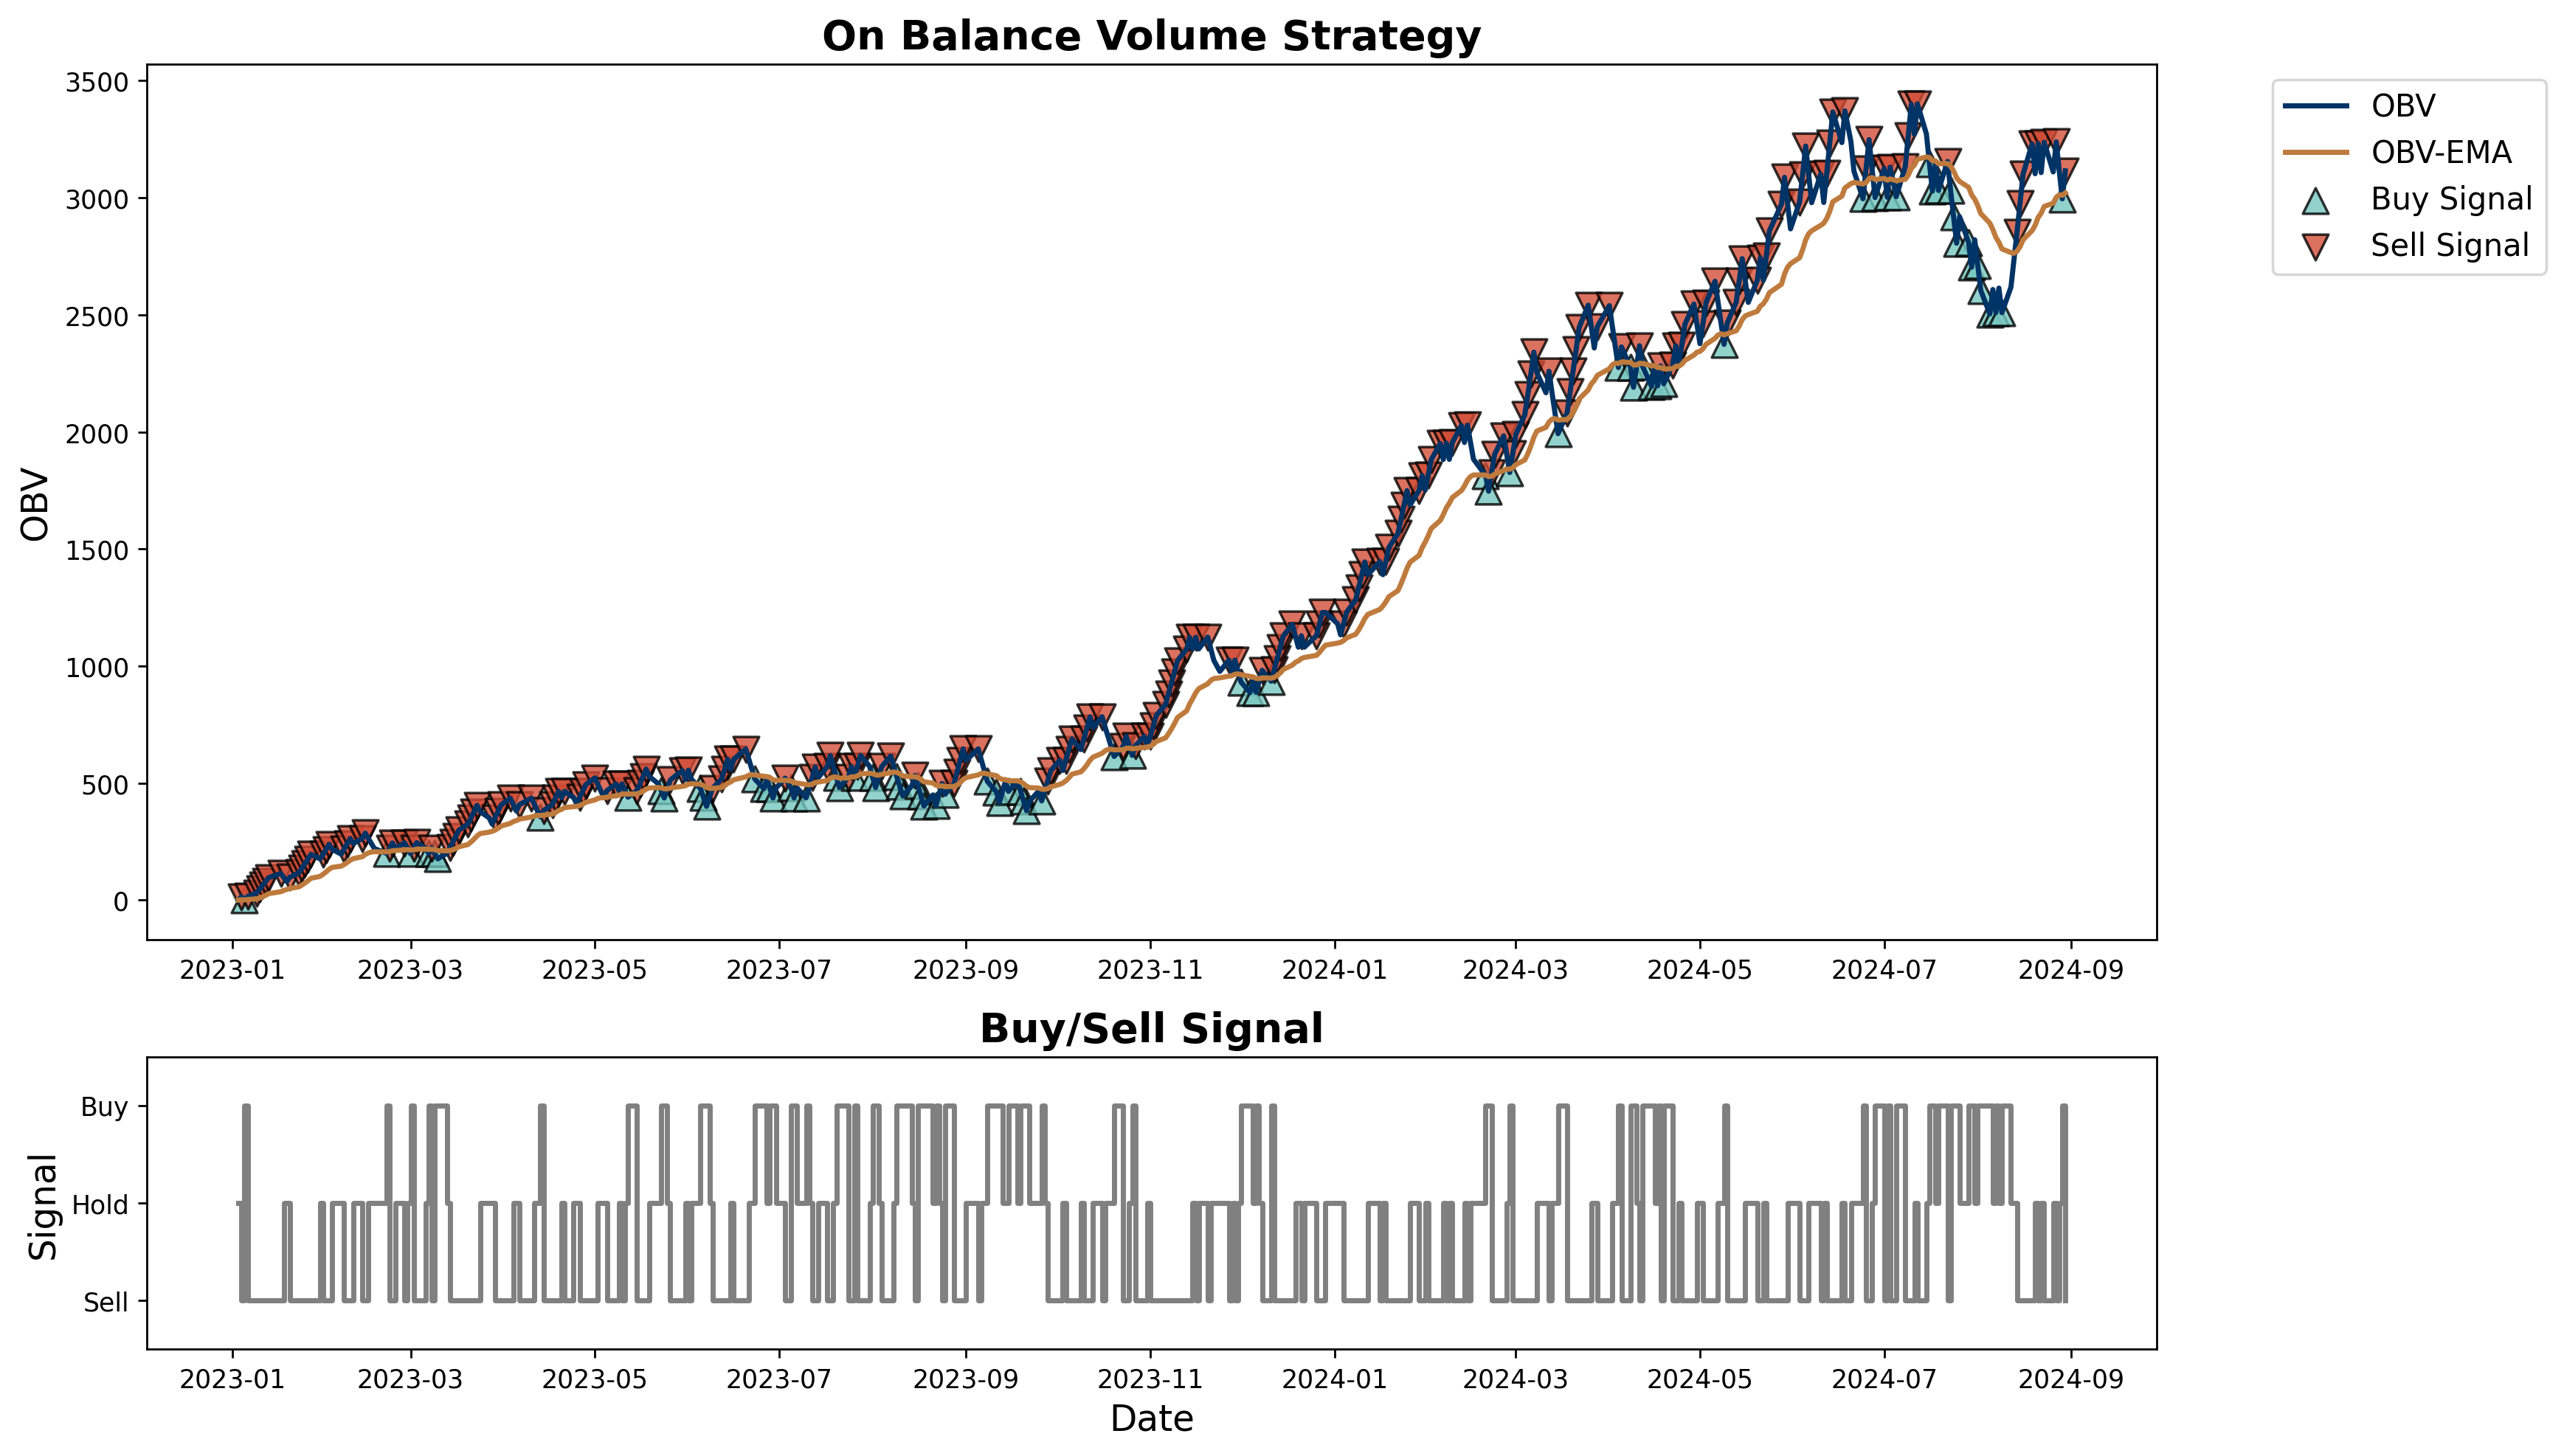

In [263]:
def calculate_obv(data):
    # set OBV with zeros
    obv = [0]  
    
    for i in range(1, data.shape[0]):
        current_close = data.loc[i,'Close']
        previous_close = data.loc[i-1,'Close']        
        current_volume = data.loc[i,'Close']
        # If Current's close is higher than last day -> add today's vol
        if current_close > previous_close:
            obv.append(obv[-1] + current_volume)
        # If Current's close is lower than last day  -> min today's vol
        elif current_close < previous_close:
            obv.append(obv[-1] - current_volume)
        # If Current's close is equal to last day, -> keep 
        else:
            obv.append(obv[-1])
    
    data['OBV'] = obv
    return data['OBV']

# Calculate OBV
def on_balance_volume_strategy(data, window):
    data = data.copy()

    # obv
    data['OBV']= calculate_obv(data)
    data['OBV_EMA'] = data['OBV'].ewm(span=window, adjust=False).mean()
    
    #If OBV > OBV_EMA Then Buy 
    data['OBV Signal'] = np.where(
        (data['OBV'] < data['OBV_EMA'])& (data['Close'].diff() < 0), 'Buy',  
        np.where(
            (data['OBV'] > data['OBV_EMA'])& (data['Close'].diff() > 0), 'Sell', 
            'Hold'  
        )
    )
    return data

# Visualize long / short results of on_balance_volume_strategy
import matplotlib.pyplot as plt

def Visualize_signal_obv(data):
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), dpi=250, gridspec_kw={'height_ratios': [3, 1]})

    # 上面的均值回归图
    ax1 = axs[0]
    ax1.plot(data.set_index('Date')['OBV'], label='OBV', color='#003366', linewidth=2)
    ax1.plot(data.set_index('Date')['OBV_EMA'], label='OBV-EMA', color='#BF7B3D', linewidth=2)

    buy_signals = data[data['OBV Signal'] == 'Buy']
    sell_signals = data[data['OBV Signal'] == 'Sell']

    ax1.scatter(buy_signals.set_index('Date').index, 
                buy_signals['OBV'], 
                marker='^', 
                color='#76C7C0', 
                label='Buy Signal', 
                s=100, 
                alpha=0.8, 
                edgecolor='black')
    ax1.scatter(sell_signals.set_index('Date').index, 
                sell_signals['OBV'], 
                marker='v', 
                color='#D24D37', 
                label='Sell Signal', 
                s=100, 
                alpha=0.8, 
                edgecolor='black')

    ax1.set_title("On Balance Volume Strategy", fontsize=16, fontweight='bold')
    ax1.set_ylabel("OBV", fontsize=14)
    ax1.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1.05, 1))

    # 下面的买入卖出信号的方形波图
    ax2 = axs[1]
    ax2.step(data.set_index('Date').index, 
             data['OBV Signal'].replace({'Buy': 1, 'Sell': -1, 'Hold': 0}),
             where='post', 
             color='gray', linewidth=2)
    ax2.set_ylim(-1.5, 1.5)  # 设置y轴范围
    ax2.set_yticks([-1, 0, 1])
    ax2.set_yticklabels(['Sell', 'Hold', 'Buy'])
    ax2.set_title("Buy/Sell Signal", fontsize=16, fontweight='bold')
    ax2.set_xlabel("Date", fontsize=14)
    ax2.set_ylabel("Signal", fontsize=14)

    plt.tight_layout()
    plt.show()



df_obv = on_balance_volume_strategy(data, window=20)
Visualize_signal_obv(df_obv)

In [ ]:
def generate_trading_signals(df, lookback_period=14, ma_short=50, ma_long=200, volatility_multiplier=2):
    # 计算移动平均线
    df['MA_short'] = df['Close'].rolling(window=ma_short).mean()
    df['MA_long'] = df['Close'].rolling(window=ma_long).mean()
    
    # 计算布林带
    df['volatility'] = df['Close'].rolling(window=lookback_period).std()
    df['upper_band'] = df['MA_short'] + volatility_multiplier * df['volatility']
    df['lower_band'] = df['MA_short'] - volatility_multiplier * df['volatility']

    # 策略 1: 趋势跟随策略（MA交叉）
    df.loc[(df['MA_short'] > df['MA_long']) & (df['MA_short'].shift(1) <= df['MA_long'].shift(1)), 'Signal'] = 1
    df.loc[(df['MA_short'] < df['MA_long']) & (df['MA_short'].shift(1) >= df['MA_long'].shift(1)), 'Signal'] = -1

def generate_trading_signals(df, lookback_period=14, ma_short=50, ma_long=200, volatility_multiplier=2):
    """
    根据不同策略生成买入和卖出信号。
    
    参数:
    - df: 包含日期索引的DataFrame，需包含 'Close' 和 'Volume' 列。
    - lookback_period: 动量和RSI的回溯周期，默认为14。
    - ma_short: 短期移动平均线窗口大小。
    - ma_long: 长期移动平均线窗口大小。
    - volatility_multiplier: 用于布林带的波动性倍数。
    
    返回:
    - signals: DataFrame，包含买入 ('Buy') 和卖出 ('Sell') 信号。
    """
    # 计算移动平均线
    df['MA_short'] = df['Close'].rolling(window=ma_short).mean()
    df['MA_long'] = df['Close'].rolling(window=ma_long).mean()
    
    # 计算布林带
    df['volatility'] = df['Close'].rolling(window=lookback_period).std()
    df['upper_band'] = df['MA_short'] + volatility_multiplier * df['volatility']
    df['lower_band'] = df['MA_short'] - volatility_multiplier * df['volatility']
    
    # 计算RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=lookback_period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=lookback_period).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # 计算动量
    df['momentum'] = df['Close'].diff(lookback_period)
    
    # 计算OBV
    df['OBV'] = (np.sign(delta) * df['Volume']).cumsum()
    
    # 初始化信号列
    df['Buy'] = False
    df['Sell'] = False
    
    # 策略 1: 趋势跟随策略（MA交叉）
    df.loc[(df['MA_short'] > df['MA_long']) & (df['MA_short'].shift(1) <= df['MA_long'].shift(1)), 'Buy'] = True
    df.loc[(df['MA_short'] < df['MA_long']) & (df['MA_short'].shift(1) >= df['MA_long'].shift(1)), 'Sell'] = True
    
    # 策略 2: 动量交易策略（RSI 超买超卖）
    df.loc[df['RSI'] < 30, 'Buy'] = True
    df.loc[df['RSI'] > 70, 'Sell'] = True
    
    # 策略 3: 配对交易策略（布林带）
    df.loc[df['Close'] < df['lower_band'], 'Buy'] = True
    df.loc[df['Close'] > df['upper_band'], 'Sell'] = True
    
    # 策略 4: OBV 分析
    df.loc[(df['OBV'].diff() > 0) & (df['momentum'] > 0), 'Buy'] = True
    df.loc[(df['OBV'].diff() < 0) & (df['momentum'] < 0), 'Sell'] = True
    
    # 去重信号
    df['Buy'] = df['Buy'] & ~df['Buy'].shift().fillna(False)
    df['Sell'] = df['Sell'] & ~df['Sell'].shift().fillna(False)
    
    # 返回包含信号的DataFrame
    signals = df[['Close', 'MA_short', 'MA_long', 'upper_band', 'lower_band', 'RSI', 'OBV', 'Buy', 'Sell']]
    return signals



def calculate_obv(df):
    """
    计算OBV指标，并生成买入和卖出信号。
    
    参数:
    - df: 包含 'Close' 和 'Volume' 列的DataFrame。
    
    返回:
    - df: 包含计算后的 'OBV' 和 'OBV_signal' 列的DataFrame。
    """
    # 初始化OBV值
    df['OBV'] = 0
    df['OBV'][1:] = np.where(df['Close'][1:] > df['Close'][:-1].values,
                             df['Volume'][1:],
                             np.where(df['Close'][1:] < df['Close'][:-1].values, 
                                      -df['Volume'][1:], 0)).cumsum()

    # OBV买卖信号：当OBV上升且价格有上涨趋势时买入，反之卖出
    df['OBV_signal'] = np.where((df['OBV'].diff() > 0) & (df['Close'].diff() > 0), 'Buy',
                                np.where((df['OBV'].diff() < 0) & (df['Close'].diff() < 0), 'Sell', 'Hold'))
    
    return


# 加载数据 (假设已经加载到df中)
signals = generate_trading_signals(df)

# 仅显示生成的买入和卖出信号
buy_signals = signals[signals['Buy']]
sell_signals = signals[signals['Sell']]
print(buy_signals, sell_signals)


# Plot cumulative returns
plt.figure(figsize=(14, 8), dpi=250)
plt.plot(data_sma.set_index('Date')['Cumulative Normal Return'], label='Cumulative Normal Return', color='blue')
plt.plot(data_sma.set_index('Date')['Cumulative Strategy Return'], label='Cumulative Strategy Return', color='orange')
plt.title(f"{stock_symbol} Mean Reversion Strategy vs Normal Return")
plt.legend()
plt.show()


def MR_Strategy(df,lookback=20,buy_threshold=-1.5,sell_threshold=1.5,cost=0.0):
    '''输入参数：
    df为数据表: 包含open,close,low,high,vol，标的收益率rets，指数收益率数据hs300
    lookback为均值回归策略参数，设置统计区间长度，默认20天
    buy_threshold:买入参数，均值向下偏离标准差的倍数，默认-1.5
    sell_threshold:卖出参数，均值向上偏离标准差的倍数，默认1.5
    cost为手续费+滑点价差，可以根据需要进行设置，默认为0.0
    '''
    #计算均值回归策略的Zscore值
    df = df.copy()
    df['rets']=df.Close.pct_change().dropna()

    
    ret_lb=df['Close'].rolling(lookback).mean()
    std_lb=df['Close'].rolling(lookback).std()
    df['score']=(df['Close']-ret_lb)/std_lb
    df.dropna(inplace=True)
    
    #设计买卖信号，为尽量贴近实际，加入涨跌停不能买卖的限制
    #当Zscore值小于-1.5且第二天开盘没有涨停发出买入信号设置为1
    df.loc[(df.score<buy_threshold) &(df['Open'] < df['Close'].shift(1) * 1.097), 'Signal'] = 1
    #当Zscore值大于1.5且第二天开盘没有跌停发出卖入信号设置为0
    df.loc[(df.score>sell_threshold) &(df['Open'] > df['Close'].shift(1) * 0.903), 'Signal'] = 0
    
    df['position']=df['signal'].shift(1)
    df['position'].fillna(method='ffill',inplace=True)
    df['position'].fillna(0,inplace=True)
    
    #根据交易信号和仓位计算策略的每日收益率
    df.loc[df.index[0], 'capital_ret'] = 0
    #今天开盘新买入的position在今天的涨幅(扣除手续费)
    df.loc[df['position'] > df['position'].shift(1), 'capital_ret'] = \
                         (df['Close'] / df['Open']-1) * (1- cost) 
    #卖出同理
    df.loc[df['position'] < df['position'].shift(1), 'capital_ret'] = \
                   (df['Open'] / df['Close'].shift(1)-1) * (1-cost) 
    
    # 当仓位不变时,当天的capital是当天的change * position
    df.loc[df['position'] == df['position'].shift(1), 'capital_ret'] = \
                        df['rets']*df['position']
    #计算标的、策略、指数的累计收益率
    df['capital_line']=(df.capital_ret+1.0).cumprod()
    df['rets_line']=(df.rets+1.0).cumprod()
    
    return df


# Apply the Z-score-based strategy
data_sma_zscore = mean_reversion_strategy_with_zscore(data, midprice_type="EMA", window=20, z_threshold=1.5)

# Visualize and analyze results
plt.figure(figsize=(14, 8), dpi=250)
plt.plot(data_sma_zscore.set_index('Date')['Close'], label='Close Price', color='blue')
plt.plot(data_sma_zscore.set_index('Date')['Midprice'], label='Midprice (EMA)', color='orange')
plt.plot(data_sma_zscore.set_index('Date')['Upper Bound'], label='Upper Bound', color='green', linestyle='--')
plt.plot(data_sma_zscore.set_index('Date')['Lower Bound'], label='Lower Bound', color='red', linestyle='--')
plt.fill_between(data.set_index('Date').index, data_sma_zscore['Lower Bound'], data_sma_zscore['Upper Bound'], color='gray', alpha=0.3)

# Show buy and sell signals
buy_signals = data_sma_zscore[data_sma_zscore['Signal'] == 'Buy']
sell_signals = data_sma_zscore[data_sma_zscore['Signal'] == 'Sell']
plt.scatter(buy_signals.set_index('Date').index, buy_signals['Close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.set_index('Date').index, sell_signals['Close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.title(f"Mean Reversion Strategy with Z-score (Threshold = 2)")
plt.legend()
plt.show()


df2 = MR_Strategy(df,lookback=20,buy_threshold=-1.5,sell_threshold=1.5,cost=0.0)
df2[['capital_line','rets_line']].head(100)


# Plot cumulative returns
plt.figure(figsize=(14, 8), dpi=250)
plt.plot(df2.set_index('Date').index, df2['rets_line'], label='Cumulative Normal Return', color='blue')
plt.plot(df2.set_index('Date').index, df2['capital_line'], label='Cumulative Strategy Return', color='orange')
plt.title("Mean Reversion Strategy vs Normal Buy-and-Hold Return")
plt.legend()
plt.show()


sell = percentile_values[-1]
buy = percentile_values[0]
df['SMA Signal'] = 

np.where(data['Close'] < lower_bound, 'Buy', 

                              np.where(data['Close'] > upper_bound, 'Sell', 'Hold'))



plt.figure(figsize=(14,7))
plt.title('Ratios')
df['Spread'].dropna().plot()
plt.axhline(percentile_values[0], c='green', label='15 percentile')
plt.axhline(percentile_values[2], c='brown', label='50 percentile')
plt.axhline(percentile_values[-1], c='red', label='85 percentile')
plt.legend()